In [5]:
!pip install numpy==1.23.5
!pip install pmdarima==1.8.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have num

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.7/639.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pmdarima
  Running setup.py clean for pmdarima
Failed to build pmdarima
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pmdarima)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")

co2 = pd.read_csv(
    'https://zenodo.org/records/10951538/files/arima_co2.csv?download=1',
    header=0,
    names=['idx', 'co2'],
    skipfooter=2,
    engine='python'
)


co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)
co2 = co2.asfreq('MS')
co2 = co2.interpolate()

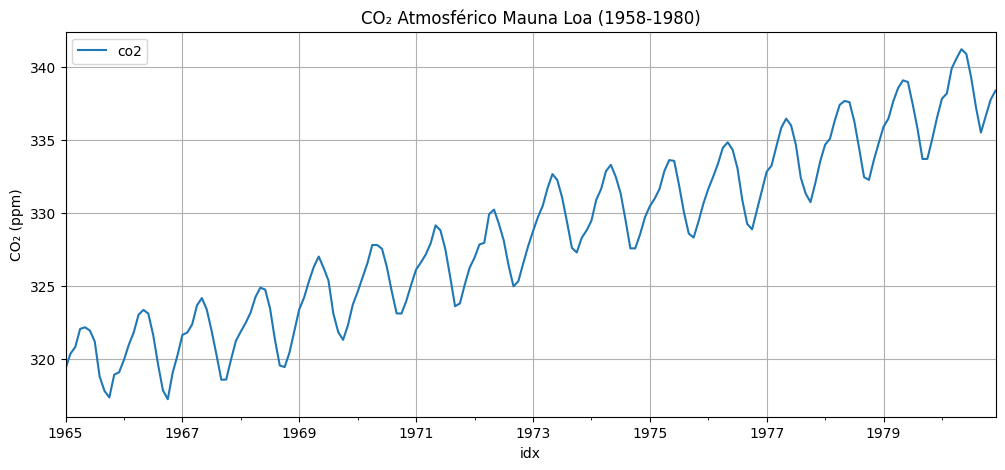

In [2]:
co2.plot(title='CO₂ Atmosférico Mauna Loa (1958-1980)', figsize=(12,5))
plt.ylabel('CO₂ (ppm)')
plt.grid()
plt.show()

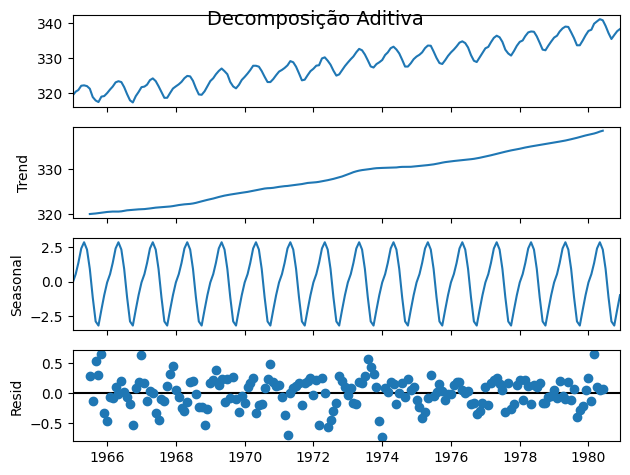

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(co2, model='additive', period=12)
decomp.plot()
plt.suptitle('Decomposição Aditiva', fontsize=14)
plt.show()

In [4]:
result = adfuller(co2['co2'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 1.269677149003227
p-value: 0.9964336403294772


In [5]:
split_index = int(len(co2) * 0.9)
train = co2.iloc[:split_index]
test = co2.iloc[split_index:]

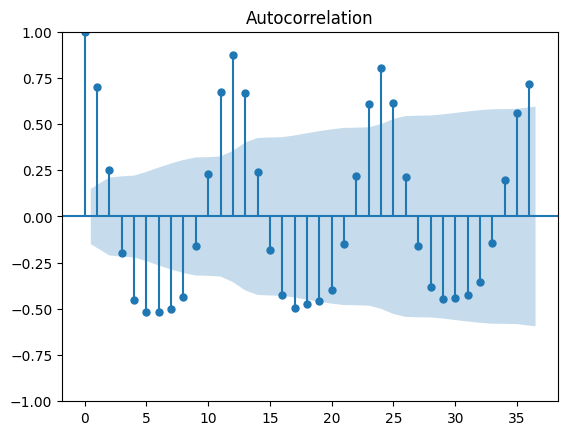

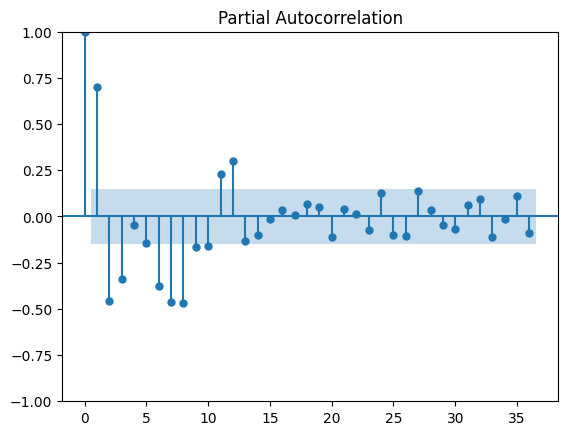

In [6]:
plot_acf(train['co2'].diff().dropna(), lags=36)
plt.show()

plot_pacf(train['co2'].diff().dropna(), lags=36)
plt.show()

In [7]:
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12
parameters = list(itertools.product(p, d, q, P, D, Q))
best_aic = np.inf
best_params = None
best_model = None

for param in parameters:
    try:
        model = SARIMAX(train['co2'],
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
    except:
        continue

print("Melhores parâmetros:", best_params)
print("AIC:", best_aic)

Melhores parâmetros: (0, 1, 1, 1, 1, 1)
AIC: 65.24332152690634


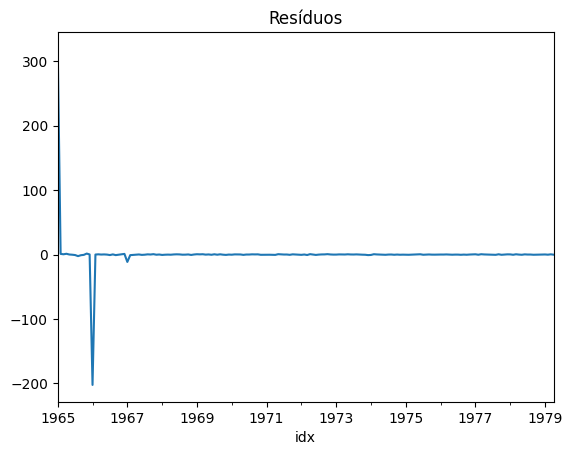

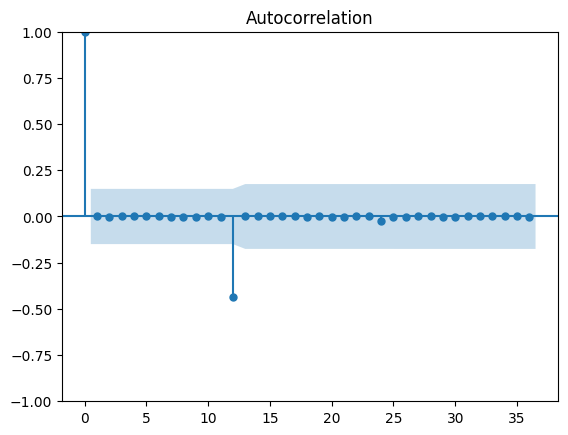

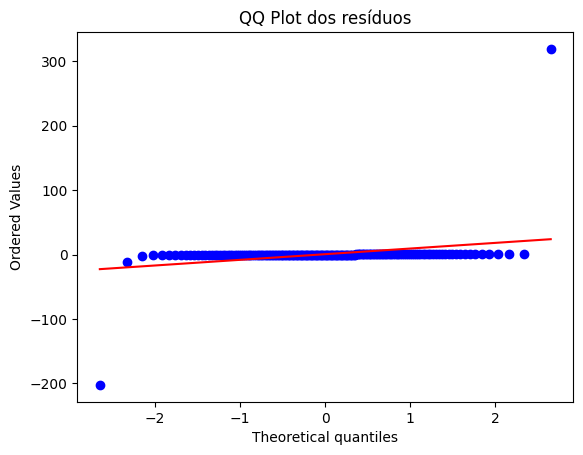

In [8]:
residuals = best_model.resid
residuals.plot(title='Resíduos')
plt.show()

plot_acf(residuals, lags=36)
plt.show()

import scipy.stats as stats
stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('QQ Plot dos resíduos')
plt.show()

In [10]:
auto_model = auto_arima(train['co2'], seasonal=True, m=12,
                        trace=True, error_action='ignore', suppress_warnings=True)

print("AutoARIMA summary:")
print(auto_model.summary())

# Previsões
sarimax_pred = best_model.get_forecast(steps=len(test)).predicted_mean
auto_pred = auto_model.predict(n_periods=len(test))

# Métricas
def eval(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

print("SARIMAX:", eval(test['co2'], sarimax_pred))
print("AutoARIMA:", eval(test['co2'], auto_pred))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=305.476, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=112.452, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=546.385, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=157.068, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=109.821, Time=3.77 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=289.087, Time=1.44 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=108.770, Time=3.12 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=112.683, Time=0.97 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=110.713, Time=